In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, resnet50

In [2]:
%matplotlib inline
# from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from IPython.display import display

In [3]:
model = resnet50(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# load labels
! wget "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
# ! wget "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-2014_2017.txt"

with open("imagenet1000_clsidx_to_labels.txt", 'r') as f:
    imagenet_labels = f.readlines()

--2020-09-20 23:14:21--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2020-09-20 23:14:22 (2.75 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [5]:
from torchvision import models, datasets, transforms
from PIL import Image
from matplotlib.pyplot import imshow

In [6]:
from torchvision import models, datasets, transforms
from PIL import Image
from matplotlib.pyplot import imshow

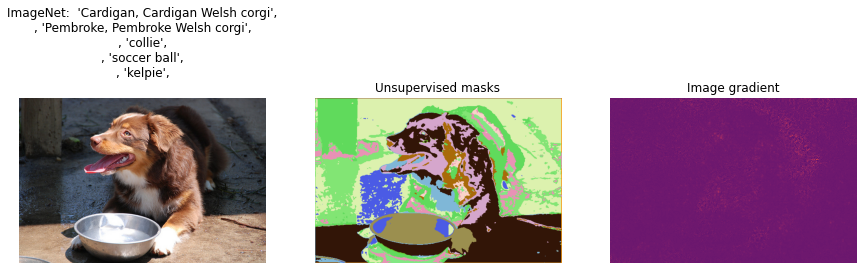

In [19]:
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

images_folder = '/content/drive/My Drive/Course Work/Algo 2014/images/dogs/'
masks_folder = '/content/drive/My Drive/Course Work/Algo 2014/masks/dogs/'

img_index = 2
image_path = images_folder + f"dog_{img_index}.png"
mask_path = masks_folder + f"output_{img_index}.png"

pil_image = Image.open(image_path)
  
tensor_image = transform(pil_image)
tensor_image = tensor_image.unsqueeze(0)
tensor_image.requires_grad = True
output = model(tensor_image)

# Display Top 5 class names
imnet_descr_labels = []
top_class_indexes = np.argsort(output[0].detach().numpy())[-5:]
for i in np.flip(top_class_indexes):
  imnet_descr_labels.append(imagenet_labels[i].split(":")[1])  
imagenet_descr = "ImageNet: " + ",".join(imnet_descr_labels)
title = imagenet_descr
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title(title)
imshow(pil_image);

plt.subplot(1, 3, 2)
plt.axis('off')
pil_mask = Image.open(mask_path)
plt.title("Unsupervised masks")
imshow(pil_mask);

plt.subplot(1, 3, 3)
plt.axis('off')
current_score = output[0][top_class_indexes[0]]
current_score.backward()
image_grad = tensor_image.grad[0].numpy().max(axis=0)
plt.title("Image gradient")
plt.imshow(image_grad, cmap='inferno');

In [20]:
pil_mask = np.array(Image.open(mask_path))
print(type(pil_mask))

<class 'numpy.ndarray'>


In [25]:
strongest_colors = []
for i in range(pil_mask.shape[0]):
  for j in range(pil_mask.shape[1]):
    new_tuple = tuple(pil_mask[i, j])
    strongest_colors.append((image_grad[i, j], new_tuple))
strongest_colors = list(set([x[1] for x in sorted(strongest_colors)[:5]]))
print(strongest_colors)

[(250, 210, 201), (96, 218, 92)]


In [26]:
colors_to_power = {}
for i in range(pil_mask.shape[0]):
  for j in range(pil_mask.shape[1]):
    new_tuple = tuple(pil_mask[i, j])
    if new_tuple in strongest_colors:
      if new_tuple in colors_to_power:
        colors_to_power[new_tuple] += image_grad[i, j]
      else:
        colors_to_power[new_tuple] = image_grad[i, j]

In [28]:
sorted_colors = [sorted(list(colors_to_power.items()), key=lambda x: x[1], reverse=True)[i] for i in range(min(len(colors_to_power), 5))]
print(sorted_colors)

[((96, 218, 92), 43.694763), ((250, 210, 201), 5.678162)]


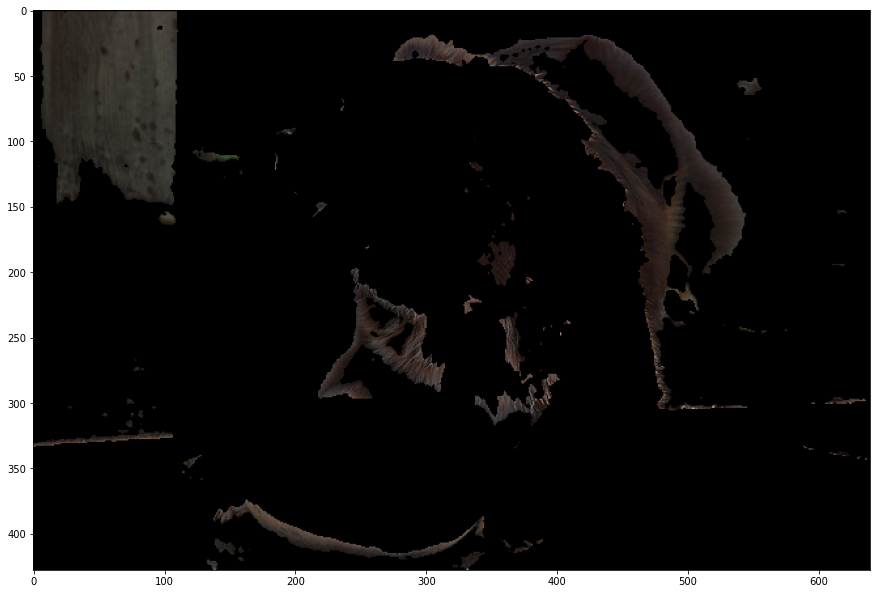

In [34]:
new_image = np.array(Image.open(image_path))
for i in range(pil_mask.shape[0]):
  for j in range(pil_mask.shape[1]):
    new_tuple = tuple(pil_mask[i, j])
    if new_tuple != sorted_colors[0][0]: # or new_tuple == sorted_colors[1][0]:
      new_image[i, j, :] = np.zeros(3)
imshow(new_image);